<a href="https://colab.research.google.com/github/clairecoffey/project/blob/master/claire_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness and the bias-variance trade-off 

## Claire Coffey

## June 2020

In this notebook we are studying bias and variance errors in the context of fairness, by exploring recidivism data. 

## Imports and Setup

Imports: first import the relevant libraries used throughout. 

In [0]:
  from sklearn import svm

In [0]:
# imports
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy as np
import pandas as pd

# Read in recidivism data 

In this notebook we are studying recidivism data. We utilise the COMPAS recidivism dataset, which uses recidivism data from Broward County jail and has been explored in the following studies:

"The accuracy, fairness, and limits of predicting recidivism", paper available at:
https://advances.sciencemag.org/content/4/1/eaao5580#corresp-1

"Machine Bias" ProPublica article, available at:
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

The dataset used can be found at:
https://github.com/propublica/compas-analysis


Here we import and read in the recidivism data. Currently, we are using a selection of 1000 samples from this dataset for our predictions (the first 1000 samples of the dataset)

We use a selection 
of fields from this dataset to predict recidivism classification (1 = will reoffend; 0 = will not reoffend). 

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:

def load_file():
  full_data = False
  print("loading data")
  if full_data:
    # full dataset
    file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/compas-scores-two-years%20-%20compas-scores-two-years.csv?token=ABPC6VNTFTGQBANNUJY2O4C6XGJGY"
  else:
    # small subset of first 500/1000/2000 people
    # file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/500-compas-scores-two-years%20-%20Sheet1%20(1).csv?token=ABPC6VOW7CBEIIGZVE6ZJYS6YKNHO"
    # file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/1000-compas-scores-two-years%20-%20Sheet1.csv"
    file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/2000-compas-scores-2-years.csv"

  # load CSV contents
  all_data = pd.read_csv(file_path, delimiter=',', dtype={'sex': 'category', 
                                                          'age_cat': 'category',
                                                          'race': 'category',
                                                          'c_charge_degree': 'category',
                                                          'c_charge_desc': 'category',
                                                          'r_charge_degree': 'category',
                                                          'r_charge_desc': 'category',
                                                          'vr_charge_degree': 'category',
                                                          'vr_charge_desc': 'category'
                                                          })
  print('loaded data')
  #shuffle into random order so we aren't always testing/training with the same people
  #but reset index (each individual still has the same ID)
  all_data = all_data.sample(frac=1).reset_index(drop=True)
  return all_data


In [0]:
# all_data = load_file()
# all_data

## Import and process data


We import the data into a pandas DataFrame. We begin by cleaning the data, so the crime descriptions are simplified, removing duplicate categories. For example, we merge descriptions such as 'possession of cocaine' and 'possess cocaine', or 'burglary/weapon' and 'burglary and weapon', by removing prepositions, and replacing abreviations and similies. 

Then,  the categorical data is  split into different fields for each category, and encoded as 0 or 1. For example, an individual with characteristic "sex: male" would be encoded as "male: 1, female: 0". The sex category is then removed.

We then consider which fields to use for prediction. This includes the removal of any fields/columns which contain many NaN values, since these cannot be handled by the classifiers. We choose to remove the columns with many NaNs rather than using an alternative approach such as replacing them with the average so as not to introduce other types of bias. We also then remove rows/individuals containing any further NaN values so there is no longer any NaN values present in the data. 

We then normalise all of the data in the dataframe, so that when fed into the classifier, the predicitons are not skewed (and potentially different forms of bias introduced).  We do this by using the StandardScaler in the sklearn preprocessing library, and we normalise the data to have a variance of 1.

Finally, we define the number of testing/training samples desired and split the data into these two sets appropriately.


In [0]:
from sklearn import preprocessing

def clean_descriptions(description):
  description = description.replace(' and ', ' ')
  description = description.replace(' / ', ' ')
  description = description.replace('possession', 'posess')
  description = description.replace('possessing', 'posess')
  description = description.replace('with', 'w/')
  description = description.replace('w/ ', 'w/')
  description = description.replace('w/', ' ')
  description = description.replace('attempted', 'att')
  description = description.replace('attempt', 'att')
  description = description.replace('aggravated', 'agg')
  description = description.replace('aggrav', 'agg') 
  description = description.replace(' of ', ' ')
  return description

def import_data(all_data):
  num_testing_samples = 1600

  encoded_sex = (pd.get_dummies(all_data['sex']))
  all_data = all_data.drop(columns=['sex'])
  all_data = all_data.join(encoded_sex)

  encoded_age_cat = (pd.get_dummies(all_data['age_cat']))
  all_data = all_data.drop(columns=['age_cat'])
  all_data = all_data.join(encoded_age_cat)

  encoded_race = (pd.get_dummies(all_data['race']))
  all_data = all_data.drop(columns=['race'])
  all_data = all_data.join(encoded_race)

  encoded_c_charge_degree = (pd.get_dummies(all_data['c_charge_degree']))
  all_data = all_data.drop(columns=['c_charge_degree'])
  all_data = all_data.join(encoded_c_charge_degree, rsuffix='_c')

  #these are joined with suffixes because otherwise columns overlap 
  all_data['c_charge_desc'] = all_data['c_charge_desc'].astype(str).str.lower()
  all_data['c_charge_desc'] = all_data['c_charge_desc'].apply(clean_descriptions)
  encoded_c_charge_desc = (pd.get_dummies(all_data['c_charge_desc']))
  all_data = all_data.drop(columns=['c_charge_desc'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_c')

  encoded_r_charge_degree = (pd.get_dummies(all_data['r_charge_degree']))
  all_data = all_data.drop(columns=['r_charge_degree'])
  all_data = all_data.join(encoded_r_charge_degree, rsuffix='_r')

  all_data['r_charge_desc'] = all_data['r_charge_desc'].astype(str).str.lower()
  all_data['r_charge_desc'] = all_data['r_charge_desc'].apply(clean_descriptions)
  encoded_r_charge_desc = (pd.get_dummies(all_data['r_charge_desc']))
  all_data = all_data.drop(columns=['r_charge_desc'])
  all_data = all_data.join(encoded_r_charge_desc, rsuffix='_r')

  encoded_vr_charge_degree = (pd.get_dummies(all_data['vr_charge_degree']))
  all_data = all_data.drop(columns=['vr_charge_degree'])
  all_data = all_data.join(encoded_vr_charge_degree, rsuffix='_vr')

  all_data['vr_charge_desc'] = all_data['vr_charge_desc'].astype(str).str.lower()
  all_data['vr_charge_desc'] = all_data['vr_charge_desc'].apply(clean_descriptions)
  encoded_vr_charge_desc = (pd.get_dummies(all_data['vr_charge_desc']))
  all_data = all_data.drop(columns=['vr_charge_desc'])
  all_data = all_data.join(encoded_vr_charge_desc, rsuffix='_vr')

  all_data = all_data.drop(columns=['nan'])
  all_data = all_data.drop(columns=['nan_vr'])
  all_data = all_data.drop(columns=['nan_r'])

  #drop columns not used for predictions, including info such as names, and columns with many NaN values 
  all_data.columns = map(str.lower, all_data.columns)
  #dont use individual crimes, too much and too slow, only use severity of crimes and other info
  all_data_simplified = all_data[['juv_fel_count','juv_misd_count','juv_other_count','priors_count','is_recid','is_violent_recid','event','female','male','25 - 45','greater than 45','less than 25','african-american','asian','caucasian','hispanic','native american','other','f','m','(f1)','(f2)','(f3)','(f6)','(m1)','(m2)','(mo3)']]

  #remove rows containing NaN values 
  all_data_simplified = all_data_simplified.dropna()

  #Renormalise the data so we have unit variance and mean 0 using built-in preprocessing method in sklearn
  scaler = preprocessing.StandardScaler()
  all_data_scaled = pd.DataFrame(scaler.fit_transform(all_data_simplified),columns=all_data_simplified.columns)

  # print("testing normalisation, printing mean and variance: ")
  # print(all_data_scaled.mean())
  # print(all_data_scaled.var())

  all_data_and_labels = all_data_scaled.join(all_data[['two_year_recid']])

  #split into training and testing with specific number of testing samples
  #and training set to be the remainder
  testing_data_and_labels = all_data_and_labels[:num_testing_samples]
  training_data_and_labels = all_data_and_labels[num_testing_samples:]

  # if(demographic_to_test != 'all'):
    # testing_data_and_labels =  pd.DataFrame.reset_index(testing_data_and_labels.loc[testing_data_and_labels[demographic_to_test] > 0],drop=True)

  print("training data:")
  print(training_data_and_labels)
  print("testing data")
  print(testing_data_and_labels)

  return training_data_and_labels, testing_data_and_labels


In [0]:
# training_data_and_labels, testing_data_and_labels = import_data(all_data)
# training_data_and_labels

# Classification

##Selecting Classifiers

Here we select the classification model to use. We are using a selection of built-in classifiers in scikit-learn. 

Currently, we are using RBF SVM models (https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

We define the boolean values ```vary_gamma ``` and  ```vary_c``` to define whether we are varying the gamma or C parameters; C defines the misclassification penalty and gamma defines the spread of the kernel. 



In [0]:
from sklearn import model_selection, neighbors, svm, gaussian_process, tree, ensemble, neural_network, metrics

def define_classifiers():

  vary_gamma = False
  vary_c = False 
  polynomial = True
  gammas = []
  cs = []
  classifiers = []
  degrees = []

  if vary_gamma:
    gammas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,5,10,50,100,500,1000]
    # gammas = [100, 1000, 10000, 100000]
    cs=[10000]
    # cs = [0.1, 1, 10, 100, 1000, 10000, 100000]
    # gammas = [0.001]
    # gammas = [1]
    # c_val = 1000
    #fix size of C if varying gamma

    for gamma_val in gammas:
      for c_val in cs:
        classifiers.append(svm.SVC(gamma=gamma_val,C=c_val, probability=True))

  if vary_c:
    cs = [10, 100, 1000, 10000, 100000, 1000000, 10000000, 10000000]
    gamma_val = 1
    #fix size of gamma if varying C
    for c_val in cs:
      classifiers.append(svm.SVC(gamma=gamma_val,C=c_val, probability=True))

  if polynomial:
    # degrees = [1,2,3,4,5,6,7,8]
    degrees = [0]
    for degree in degrees:
      classifiers.append(svm.SVC(kernel='poly', degree=degree, probability=True, C=1000))

  return classifiers, gammas, cs, degrees


In [0]:
# define_classifiers()

## Bootstrapping 

The classification process then uses a bootstrapping procedure with the chosen model, to generate predictions of recidivism classifications (1 = will not reoffend (positive case); 0 = will reoffend (negative case)).

Bootstrapping (https://link.springer.com/chapter/10.1007/978-1-4612-4380-9_41) is a sampling with replacement procedure. The sample size is the same as the size of the (training) dataset. The bootstrapping procedure is run many times to generate different training datasets, which will then be used for classification. In turn, the classification results will be used to calculate and study the bias and variance errors. 

In [0]:
def do_bootstrap(training_data_and_labels):
  # this is one bootstrap sample 
  indices = np.random.randint(0,training_data_and_labels.shape[0] , training_data_and_labels.shape[0])
  indices.sort()
  data_points = []

  for i in indices:
    data_points.append(training_data_and_labels.iloc[i])

  b_sample = pd.DataFrame(data_points)
  
  return b_sample

In [0]:
# b_sample = do_bootstrap(training_data_and_labels)

### Calculate average prediction for each individual over all bootstrap samples 

In [0]:
def calculate_avg_prediction(predictions):
  #each row is bootstrap sample, each column an individual
  return majority_predictions

## Perform classification


Fit the model on the training data (which is one bootstrap data sample as defined above)


In [0]:
def fit_and_predict(clf, b_sample, testing_data_and_labels):

    #training data is everything apart from two year recid 0/1 label from the bootstrap sample
    X_train = b_sample.drop(columns=['two_year_recid'])
    y_train = b_sample['two_year_recid']
    X_test = testing_data_and_labels.drop(columns=['two_year_recid'])
    y_test = testing_data_and_labels['two_year_recid']

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    soft_score = clf.decision_function(X_test)
    y_true = y_test

    return y_pred, y_true, soft_score

Perform classification for each bootstrap sample separately, and store these in a DataFrame, to be passed into the bias/variance calculations.
This returns all of the predictions for each individual for each bootstrap sample

In [0]:
def classify(training_data_and_labels, testing_data_and_labels, clf):
    count = 0

    num_bootstraps = len(training_data_and_labels);
    while count <= num_bootstraps:
      b_sample = do_bootstrap(training_data_and_labels)
      y_pred, y_true, soft_score = fit_and_predict(clf, b_sample, testing_data_and_labels)
      # calc_conf_matrix_bootstrap(y_true, y_pred)
      if(count == 0):
        predictions = pd.DataFrame(pd.Series(y_pred)).transpose()
        #true labels are the same for every sample so we only need 1 row in df
        true_labels = pd.DataFrame(pd.Series(y_true)).transpose()
      else:
        predictions = predictions.append(pd.DataFrame(pd.Series(y_pred)).transpose())
      count += 1
      
    return predictions, true_labels, soft_score

In [0]:
# classify(training_data_and_labels, testing_data_and_labels, clf)


## Correcting for Fairness


#Fairness

The definition of fairness is disputed, and there is not a single correct approach to ensuring fairness in machine learning. In general, as stated in https://arxiv.org/pdf/1711.08513.pdf, fairness in machine learning can be approached in two ways: fairness of the dataset itself; fairness of the model.

Since we cannot control the process by which the data is collected, and the recidivism dataset already exists (likely with human and societal biases built-in), we will not be focusing on the former category. Although, there have been recent trends within the fairness and machine learning communities to argue the importance of the fairness in data collection, for example, in http://papers.nips.cc/paper/7613-why-is-my-classifier-discriminatory.pdf, the authors discuss the necessity of correcting for bias in the dataset, an approach which may actually increase the accuracy of the predictions, in contrast to approaches that exclusively focus on correcting for fairness in the models, at the expense of accuracy. Another area in which recent trends in fairness research have addressed is the importance of developing context-aware fairness measurements (https://arxiv.org/pdf/1805.05859.pdf). However, in our project we will focus on model-based fairness correction - ensuring the machine learning models are not perpetuating existing biases, or introducing new biases. We do this by using a widely used and accepted fairness measurement which is context-independent, known as **Equalised Odds** (http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf). This approach is not without criticism, however it provides a clear and well-motivated approach to achieving fair predictions across subgroups with different protected characteristics. We attempt to correct for fairness in relation to the protected characteristics found in the recidivism dataset (sex, race, age). Once our models are 'fair' in relation to this description, we can explore the relationship between bias and variance errors and the potential discovery of discrimination against new categories. 



##Equalised Odds

As stated above, we are considering fairness in relation to the equalised odds metric (http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf). The definition as stated in this paper is as follows: \\
We say that a predictor $\hat{Y}$ satisfies equalized odds with respect to
protected attribute $A$ and outcome $Y$, if $\hat{Y}$ and $A$ are independent conditional on $Y$. Therefore, if the classification labels are $Y$ and $\hat{Y}$, for an outcome $ y=1 $, $\hat{Y}$ has equal true positive rates across all demographic groups, for example, the categories not female and female will have equal true positive rates. For an outcome  $ y=0 $, $\hat{Y}$ has equal false positive rates across all demographic groups. This enforces equal bias and accuracy in all demographics. This can formally be stated as:
$$ Pr \left\{ \hat{Y}=1 | A = 0, Y = y \right\} = Pr \left\{ \hat{Y}=1 | A = 0, Y = y \right\} , y \in \left\{ 0,1 \right\}$$

This approach punishes models that only perform well on the majority demographics.

The following code is the implementation of equalised odds from the paper http://papers.nips.cc/paper/7151-on-fairness-and-calibration.pdf, the code is from the github repository https://github.com/gpleiss/equalized_odds_and_calibration/blob/master/eq_odds.py.

This implementation equalises false positives and false negatives across demoographics, since in general, African Americans receive
a disproportionate number of F.P. predictions as compared with Caucasians when automated risk tools are used in practice. In the context of recidivism, the 'positive case' is in fact a prediction of 0: the individual is predicted not to reoffend, so equalising false positives in this case fits with the equalised odds definition above.

In [0]:
def calculate_scores(predictions, soft_scores):

  maximum = soft_scores.max()
  minimum = soft_scores.min()

  normalise = lambda x: ((x-minimum)/(maximum-minimum))
  n_soft_scores = []
  for score in soft_scores:
    soft_score = normalise(score)
    n_soft_scores.append(soft_score)

  return n_soft_scores

In [0]:
def constrain_with_equalised_odds(true_labels, group_ids, demographic, soft_scores):

  #create csv file containing relevant fields: prediction, label, group 
  predictions = pd.DataFrame(soft_scores, columns=['prediction'])
  true_labels = pd.melt(true_labels).rename(columns={'value':'label'})
  group_ids = pd.melt(group_ids).rename(columns={'value':'group'})
  eq_odds_input = pd.concat([predictions, true_labels], axis=1)
  eq_odds_input = pd.concat([eq_odds_input, group_ids], axis=1)
  eq_odds_input = eq_odds_input.drop(columns=["variable"])
  eq_odds_input.to_csv('/content/drive/My Drive/project_data/eq_odds.csv', index=True)

  !python2 "/content/drive/My Drive/project_data/eq_odds.py" "/content/drive/My Drive/project_data/eq_odds.csv"

  eq_odds_pred_group_0 = pd.read_csv(filepath_or_buffer='/content/group_0.csv', delimiter=',', header=0)
  eq_odds_pred_group_1 = pd.read_csv(filepath_or_buffer='/content/group_1.csv', delimiter=',',header=0 )
  eq_odds_pred = pd.concat([eq_odds_pred_group_0,eq_odds_pred_group_1])
  eq_odds_pred =  pd.DataFrame.reset_index(eq_odds_pred,drop=True)
  eq_odds_pred['round_predictions'] = [0 if (row < 0.5) else 1 for row in eq_odds_pred['predictions']]

  return eq_odds_pred['round_predictions'], eq_odds_pred['true_labels']


In [0]:
from sklearn.metrics import confusion_matrix

def calc_conf_matrix(y_true, y_pred):
  # get confusion matrix and compute tn,fp,fn,tp
  tn, fp, fn, tp = confusion_matrix(y_true.iloc[0].to_numpy(), y_pred.iloc[0].to_numpy()).ravel()
  print("true negatives:", tn, "rate:" , tn/(tn+fp+fn+tp), "false positives:", fp, "rate:", fp/(tn+fp+fn+tp) ,"false negatives:", fn,"rate:", fn/(tn+fp+fn+tp), "true positives:",tp,"rate:", tp/(tn+fp+fn+tp))

In [0]:
from sklearn.metrics import confusion_matrix

def calc_conf_matrix_bootstrap(y_true, y_pred):
  # get confusion matrix and compute tn,fp,fn,tp
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  print("true negatives:", tn, "rate:" , tn/(tn+fp+fn+tp), "false positives:", fp, "rate:", fp/(tn+fp+fn+tp) ,"false negatives:", fn,"rate:", fn/(tn+fp+fn+tp), "true positives:",tp,"rate:", tp/(tn+fp+fn+tp))


# Compute bias/variance errors

We can decompose the error into the errors due to bias, and the errors due to variance, in order to study the behaviour of the model and the bias/variance tradeoff, as described by Domingos in:
https://www.aaai.org/Papers/AAAI/2000/AAAI00-086.pdf

The definitions of bias and variance are as follows:


* **Bias** is the zero-one loss incurred for the main prediction relative to the optimal prediction. Where the "main prediction" is the modal classification for each individual across all bootstrap samples. 
*  **Variance** is the average zero-one loss incurred by all predictions relativeto the main prediction.  The variance is the loss incurred by the fluctuations around the main (modal) prediction in response to different bootstrap training sets.




<!-- https://www.stat.berkeley.edu/users/breiman/arcall96.pdf.  -->

<!-- The error is also comprised of an error due to noise (in addition to bias and variance). However, as stated in http://papers.nips.cc/paper/7613-why-is-my-classifier-discriminatory.pdf, the noise is dependent on the data, not the model, so comparing the discrimination level in the form of bias and variance errors, the noise terms cancel since they are independent of the model. Therefore, differences in bias can be explored even without knowing the underlying noise of the data.  -->
We can then calculate the overall average bias error and variance error for the model. 



In [1006]:
predictions.mode()

NameError: ignored

In [0]:
def compute_bias_variance(predictions, true_labels):

  # print("predictions: ")
  # print(predictions)
  # print("true labels: ")

  biases = []
  variances = []
  avg_errors = []
  misclassified_individuals = []
  losses = []
  noises = []
 
  #find 'main' (mode) predction - used to calculate bias error 
  main_predictions = predictions.mode(dropna=False)  
  print(main_predictions)
  main_predictions_transposed = main_predictions.copy()
  main_predictions_transposed = main_predictions_transposed.iloc[0,:]

  #compare main (modal) prediction to true prediction 
  main_predictions_misclassified_relative_to_true = main_predictions.apply(lambda z : z != true_labels.iloc[0], axis=1)
  #find whether each element is misclassified for each bootstrap sample 
  #find if each prediction is the same as the true prediction 
  predictions_misclassified_relative_to_true = predictions.apply(lambda x : x != true_labels.iloc[0], axis=1)
  #find if the predictions are the same as the main prediction - used to calculate variance error
  predictions_misclassified_relative_to_main = predictions.apply(lambda y : y != main_predictions_transposed, axis = 1)

  #count number of times misclassified for each datapoint across all bootstrap samples 
  main_misclassified_true_counts = main_predictions_misclassified_relative_to_true.apply(np.sum)
  misclassified_true_counts = predictions_misclassified_relative_to_true.apply(np.sum)
  misclassified_main_counts = predictions_misclassified_relative_to_main.apply(np.sum)
  # misclassified_noise_counts = predictions_misclassific_noise.apply(np.sum)

  #average misclassification error for each individual/datapoint 
  #same as probability of incorrect classification
  avg_true_errors = misclassified_true_counts.apply(lambda a : np.divide(a,len(predictions)))
  avg_main_errors = misclassified_main_counts.apply(lambda b : np.divide(b,len(predictions)))
  avg_main_true_errors = main_misclassified_true_counts.apply(lambda c : np.divide(c,len(main_predictions)))

  for i in range(len(avg_true_errors)):
    # if average error is less than 0.5 then it means the main prediction is the same as the optimal one
    avg_main_true_error = avg_main_true_errors[i]
    avg_true_error = avg_true_errors[i]
    avg_main_error = avg_main_errors[i]
    bias = 0 if avg_main_true_error <=0.5 else 1
    variance = avg_main_error
    #noise is the underlying variance of the data: error when the optimal and true classifications are the same
    #independent of model, we can say it is 0 as doesn't effect bias/var relationship
    #and when we tested this, it returned a value of 0 (all labels predicted correctly across all samples so no loss incurred)
    noise = 0
    c1 = ((2*(1-avg_true_error))-1)
    c2 = 1 if avg_main_true_error <= 0.5 else -1
    #loss according to domingos' decomposition
    loss = (c1*noise) + bias + (c2*variance)
    biases.append(bias)
    variances.append(variance)
    noises.append(noise)
    losses.append(loss)
    if avg_true_error > 0.5:
      misclassified_individuals.append(i)

  avg_bias = np.mean(biases)
  # avg_var = abs(np.mean(avg_errors) - avg_bias)
  avg_var = np.mean(variances)
  # avg_error = np.mean(avg_errors)
  avg_loss = np.mean(losses)
  avg_noise = np.mean(noises)

  print("average loss:") 
  print(avg_loss)
  print("average noise:")
  print(avg_noise)
  print("average bias:")
  print(avg_bias)
  print("average variance:")
  print(avg_var)

  return avg_bias, avg_var, avg_loss, misclassified_individuals

We hope to address the question: Are models that exhibit high bias errors likely to introduce new categories of discrimination? 

We can therefore look at the bias and variance errors for different models.


We want to see that if the variance is low and bias high, is it consistently discriminating against a certain subgroup, potentially introducing a new type of discrimination? Unlike other work such as http://papers.nips.cc/paper/7613-why-is-my-classifier-discriminatory.pdf, it doesn't have to be a protected characteristic.



I think perhaps after fairness correction, we can look at who is misclassified and then what they have in common? Or, we can extract each "subgroup" based on whatever characteristics and analyse these - i.e. did FPR/FNR go up/down for a different subgroup after fairness correction?  Do this in same way as we do for "demographics" initially used for fairness correction. 

# Plots

Creating the appropriate plots to visualise our results. We plot: 

1.   Bias error vs Variance error
2.   Gamma value of RBF SVM vs Variance error
3.   Gamma value of RBF SVM vs Bias error


In [0]:
import matplotlib.pyplot as plt                                  
def plot_bias_variance(biases, variances, gammas, cs, degrees, losses):   
  # print("plotting bias/var") 
  # plt.scatter(biases, variances)                                              
  # plt.title('bias vs variance errors')                                     
  # plt.xlabel('bias')                                                       
  # plt.ylabel('variance')                                                   
  # plt.show()

  # plt.scatter(gammas, variances)
  # plt.xscale('log')                                              
  # plt.title('RBF SVM, C = 100000 \n gamma size vs variance errors')                                     
  # plt.xlabel('gamma')                                                       
  # plt.ylabel('variance')                                                   
  # plt.show()                                                            

  # plt.scatter(gammas, biases)                               
  # plt.xscale('log')                                                             
  # plt.title('RBF SVM, C = 100000 \n gamma size vs bias errors')                                     
  # plt.xlabel('gamma')                                                       
  # plt.ylabel('bias')                                                   
  # plt.show()            

  # plt.scatter(gammas, losses)                               
  # plt.xscale('log')                                                             
  # plt.title('RBF SVM, C = 100000 \n gamma size vs total error')                                     
  # plt.xlabel('gamma')                                                       
  # plt.ylabel('error')                                                   
  # plt.show()   

  # plt.scatter(cs, biases)                               
  # plt.xscale('log')                                                             
  # plt.title('RBF SVM, gamma=0.1, C value vs bias errors')                                     
  # plt.xlabel('C value')                                                       
  # plt.ylabel('bias')                                                   
  # plt.show()       

  # plt.scatter(cs, variances)                               
  # plt.xscale('log')                                                             
  # plt.title('RBF SVM, gamma=0.1, C value vs variance errors')                                     
  # plt.xlabel('C value')                                                       
  # plt.ylabel('variance')                                                   
  # plt.show()    

  # plt.scatter(cs, losses)                               
  # plt.xscale('log')                                                             
  # plt.title('RBF SVM, gamma=0.1, C value vs zero-one loss')                                     
  # plt.xlabel('C value')                                                       
  # plt.ylabel('loss')                                                   
  # plt.show()   

  plt.scatter(biases, variances)                                              
  plt.title('bias vs variance errors')                                     
  plt.xlabel('bias')                                                       
  plt.ylabel('variance')                                                   
  plt.show()

  plt.scatter(degrees, variances)
  plt.title('poly SVM, degree size vs variance errors')                                     
  plt.xlabel('degree')                                                       
  plt.ylabel('variance')                                                   
  plt.show()                                                            

  plt.scatter(degrees, biases)                               
  plt.title('poly SVM, degree size vs bias errors')                                     
  plt.xlabel('degree')                                                       
  plt.ylabel('bias')                                                   
  plt.show()            

  plt.scatter(degrees, losses)                               
  plt.title('poly SVM, degree size vs generalisation errors')                                     
  plt.xlabel('degree')                                                       
  plt.ylabel('error')                                                   
  plt.show()  

#just an example of if we want to plot the misclassified individuals against a characteristic from the dataframe 
#might help to look for patterns 
def plot_misclassified(misclassified):
  misclassified.reset_index().plot(kind='scatter', x='index', y='age') 
  plt.show()

In [0]:
#download CSV file containing all the info for the individuals who are consistently misclassified (i.e. >50% of the time, resulting in bias errors)
def download_misclassified(misclassified, name):
  # misclassified = np.asarray(misclassified)
  csv_name = name+'.csv'
  # misclassified = pd.DataFrame(misclassified)
  # print(misclassified)
  # np.savetxt(csv_name, misclassified, delimiter=",")
  misclassified.to_csv(r''+name+'.csv', index=False)
  # from google.colab import files
  # files.download(csv_name)

# Main method (execute code)

Main method to run the system, executing methods in appropriate sequence. 

loading data
loaded data
training data:
      juv_fel_count  juv_misd_count  ...     (mo3)  two_year_recid
1600       1.550712       -0.181568  ... -0.080906               0
1601      -0.114991       -0.181568  ... -0.080906               0
1602      -0.114991       -0.181568  ... -0.080906               0
1603      -0.114991       -0.181568  ... -0.080906               0
1604      -0.114991       -0.181568  ... -0.080906               1
...             ...             ...  ...       ...             ...
1994      -0.114991       -0.181568  ... -0.080906               1
1995      -0.114991       -0.181568  ... -0.080906               1
1996      -0.114991       -0.181568  ... -0.080906               0
1997      -0.114991       -0.181568  ... -0.080906               0
1998       3.216414       -0.181568  ... -0.080906               0

[399 rows x 28 columns]
testing data
      juv_fel_count  juv_misd_count  ...     (mo3)  two_year_recid
0         -0.114991       -0.181568  ... -0.080906 

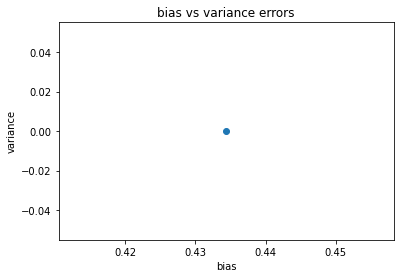

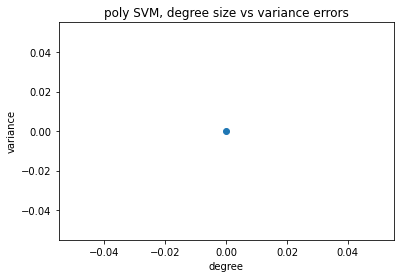

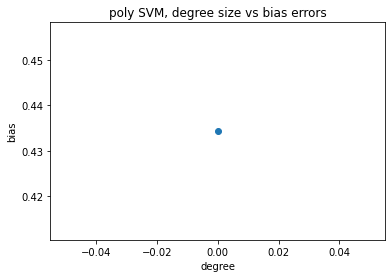

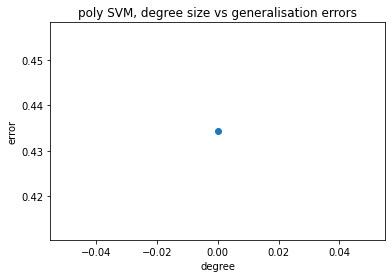

In [1011]:

all_data = load_file()
# demographics = ['african-american', 'caucasian', 'hispanic', 'asian', 'other', 'male', 'female', 'less than 25', '25 - 45', 'greater than 45']
demographics = ['african-american']
# demographics = [ 'hispanic', 'asian', 'other', 'male', 'female', 'less than 25', '25 - 45', 'greater than 45']
testing_data_and_labels_list = []
training_data_and_labels_list = []
training_data_and_labels, testing_data_and_labels = import_data(all_data)
training_data_and_labels
training_data_and_labels_list.append(training_data_and_labels)
testing_data_and_labels_list.append(testing_data_and_labels)

biases = []
variances = []
total_errors = []
avg_losses = []
biases_eq = []
variances_eq = []
total_errors_eq = []
avg_losses_eq = []
classifiers, gammas, cs, degrees = define_classifiers()
all_misclassified = pd.DataFrame()
all_misclassified_eq = pd.DataFrame()
# misclassified = []
# misclassified_eq= []
equalised_odds = False
k = 0

for classifier in classifiers:
  print(classifier)
  clf = classifier
  for i in range(len(training_data_and_labels_list)):
    predictions, true_labels, soft_scores = classify(training_data_and_labels_list[i], testing_data_and_labels_list[i], clf)  
    # predictions, true_labels = classify_noise(training_data_and_labels_list[i], testing_data_and_labels_list[i], clf)
    majority_predictions = predictions.mode(numeric_only=True)
    print("avg pred conf matrix:")
    calc_conf_matrix(true_labels, majority_predictions)
    if(equalised_odds):
      soft_scores = calculate_scores(predictions, soft_scores)
      for demographic in demographics:
        group_ids = [] 
        print("Equalising odds for ", demographic)
        group_ids_normalised = testing_data_and_labels[demographic]
        for n_id in group_ids_normalised:
          group_id = 0 if n_id < 0 else 1
          group_ids.append(group_id)
        group_ids = pd.DataFrame([group_ids])
        all_eq_predictions = []
        for j in range (len(predictions.index)):
          eq_predictions, true_eq_labels = constrain_with_equalised_odds(true_labels, group_ids, demographic, soft_scores)
          all_eq_predictions.append(np.array(eq_predictions))
        all_eq_predictions = pd.DataFrame(all_eq_predictions)
        true_eq_labels = pd.DataFrame(np.array(true_eq_labels), columns=['two_year_recid'])
        true_eq_labels = true_eq_labels.transpose()
    if(equalised_odds):
      #if not equalised odds we have to only use half of the predictions somehow otherwise it's not fair 
      #because in equalised odds we use half of it to determine parameters (validation)
      predictions = predictions.iloc[:,:int(len(predictions.columns)/2)]
      true_labels = true_labels.iloc[:,:int(len(true_labels.columns)/2)]
    # noise_predictions = noise_predictions.iloc[:,:int(len(predictions.columns)/2)]
    # print(predictions)
    # fake_predictions = predictions.replace(predictions, 0)
    # fake_true_labels = true_labels.replace(true_labels, 1)
    bias, variance, avg_loss, misclassified_individuals = compute_bias_variance(predictions, true_labels)
    biases.append(bias)
    variances.append(variance)
    avg_losses.append(avg_loss)
    if(equalised_odds):
      print("after fairness correction:")
      bias_eq, variance_eq, avg_loss_eq, misclassified_individuals_eq = compute_bias_variance(all_eq_predictions, true_eq_labels)
      biases_eq.append(bias_eq)
      variances_eq.append(variance_eq)
      avg_losses_eq.append(avg_loss_eq)
    #get the individuals which are misclassified on average (hence contributing to bias errors)
    print("misclassified before: ", misclassified_individuals)
    if(equalised_odds):
      print("misclassified after: ", misclassified_individuals_eq)
    for i in range(len(testing_data_and_labels_list)):
      if(len(misclassified_individuals) > 0 ):
        misclassified = testing_data_and_labels_list[i].iloc[misclassified_individuals]
        # print(misclassified)
        all_misclassified = all_misclassified.append(misclassified)
        # all_misclassified = pd.concat(all_misclassified, misclassified)
      if(equalised_odds):
        if(len(misclassified_individuals_eq) > 0):
          misclassified_eq = testing_data_and_labels_list[i].iloc[misclassified_individuals_eq]
          # all_misclassified_eq = pd.concat(all_misclassified_eq, misclassified_eq)
          all_misclassified_eq = all_misclassified_eq.append(misclassified_eq)
    download_misclassified(all_misclassified, str(k)+'_misclassified_before')
    if(equalised_odds):
      download_misclassified(all_misclassified_eq, str(k)+'_misclassified_after')
    k+=1
    # plot_misclassified(misclassified)
    
print("before fairness correction:")
plot_bias_variance(biases, variances, gammas, cs, degrees, avg_losses)
if(equalised_odds):
  print("after fairness correction:")
  plot_bias_variance(biases_eq, variances_eq, gammas, cs, degrees, avg_losses_eq)

loading data
loaded data
training data:
      juv_fel_count  juv_misd_count  ...     (mo3)  two_year_recid
1600      -0.114991       -0.181568  ... -0.080906               1
1601      -0.114991       -0.181568  ... -0.080906               0
1602      -0.114991       -0.181568  ... -0.080906               0
1603      -0.114991       -0.181568  ... -0.080906               0
1604      -0.114991       -0.181568  ... -0.080906               0
...             ...             ...  ...       ...             ...
1994      -0.114991       -0.181568  ... -0.080906               1
1995      -0.114991       -0.181568  ... -0.080906               1
1996      -0.114991       -0.181568  ... -0.080906               0
1997      -0.114991       -0.181568  ... -0.080906               0
1998      -0.114991       -0.181568  ... -0.080906               0

[399 rows x 28 columns]
testing data
      juv_fel_count  juv_misd_count  ...     (mo3)  two_year_recid
0         -0.114991        1.749043  ... -0.080906 

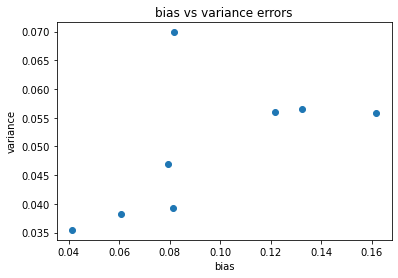

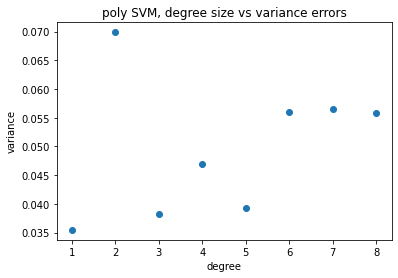

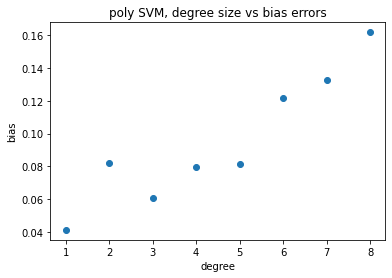

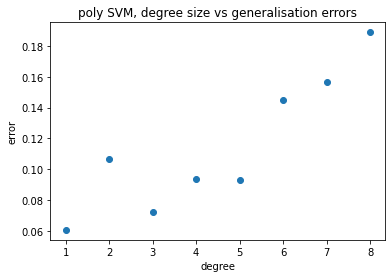

In [1004]:
main()

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')